<a href="https://colab.research.google.com/github/nasirudeenraheem/IndabaXNigeria2023/blob/main/IndabaXNigeria2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

### load the data

In [2]:
## client data
client_train = pd.read_csv('/content/drive/MyDrive/IndabaXNigeriaHack/client_train.csv')
client_test = pd.read_csv('/content/drive/MyDrive/IndabaXNigeriaHack/client_test.csv')
## invoice data
invoice_train = pd.read_csv('/content/drive/MyDrive/IndabaXNigeriaHack/invoice_train.csv')
invoice_test = pd.read_csv('/content/drive/MyDrive/IndabaXNigeriaHack/invoice_test.csv')
## sample submission
submission = pd.read_csv('/content/drive/MyDrive/IndabaXNigeriaHack/SampleSubmission (4).csv')

<ipython-input-2-ef00edadcf82>:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  invoice_train = pd.read_csv('/content/drive/MyDrive/IndabaXNigeriaHack/invoice_train.csv')


#### Investigate the data

In [3]:
client_train.head(2)

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0


In [4]:
invoice_train.head(2)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC


In [5]:
print(client_train.shape)
print(invoice_train.shape)

(135493, 6)
(4476749, 16)


**Observation**

we observe we have more records in the invoice data than client data, hence we have to merge the data into **one**, using **client_id** as the primary key.

In [9]:
## merge the train and test data
train = client_train.merge(invoice_train, on='client_id')
test = client_test.merge(invoice_test, on='client_id')

In [10]:
print(train.shape)
print(test.shape)

(4476749, 21)
(1939730, 20)


In [14]:
## check the missing value
train.isnull().sum()

disrict                 0
client_id               0
client_catg             0
region                  0
creation_date           0
target                  0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [15]:
test.isnull().sum()

disrict                 0
client_id               0
client_catg             0
region                  0
creation_date           0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [25]:
train.dtypes

disrict                   int64
client_id                object
client_catg               int64
region                    int64
creation_date            object
target                  float64
invoice_date             object
tarif_type                int64
counter_number            int64
counter_statue           object
counter_code              int64
reading_remarque          int64
counter_coefficient       int64
consommation_level_1      int64
consommation_level_2      int64
consommation_level_3      int64
consommation_level_4      int64
old_index                 int64
new_index                 int64
months_number             int64
counter_type             object
dtype: object

In [18]:
train[train.duplicated()]

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
951893,60,train_Client_125864,11,101,29/12/1998,0.0,2011-12-12,11,101545,5,...,6,1,0,0,0,0,13680,13680,2,ELEC
1755798,62,train_Client_25894,11,301,16/06/1995,0.0,2010-07-13,40,6986740,5,...,6,1,0,0,0,0,0,0,2,GAZ
2137999,60,train_Client_3636,11,101,21/11/1988,0.0,2012-01-18,40,312650,5,...,6,1,0,0,0,0,623,623,2,GAZ
2163374,60,train_Client_37069,11,101,09/03/1990,0.0,2010-10-11,11,5284,5,...,6,1,0,0,0,0,99429,99429,2,ELEC
2433919,60,train_Client_44407,11,101,15/06/1989,1.0,2008-02-28,11,66921,5,...,6,1,0,0,0,0,0,0,2,ELEC
2805729,60,train_Client_54609,11,101,16/02/1994,0.0,2010-04-06,11,200912,5,...,6,1,0,0,0,0,0,0,2,ELEC
3260191,63,train_Client_66981,51,313,20/11/1996,1.0,2006-07-17,11,132701,5,...,6,1,0,0,0,0,5946,5946,2,ELEC
3260198,63,train_Client_66981,51,313,20/11/1996,1.0,2006-07-17,11,132701,5,...,6,1,0,0,0,0,5946,5946,2,ELEC
3394719,62,train_Client_7066,11,304,12/04/2013,0.0,2014-10-28,40,4463323,5,...,6,1,0,0,0,0,80,80,2,GAZ
3462929,60,train_Client_72519,11,101,03/06/1982,0.0,2013-01-21,11,246464,5,...,6,1,0,0,0,0,2954,2954,2,ELEC


In [19]:
test[test.duplicated()]

,disrict,client_id,client_catg,region,creation_date,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
310558,63,test_Client_18456,11,379,23/09/2008,2013-11-22,40,0,5,5,6,1,0,0,0,0,0,0,2,GAZ
1226244,69,test_Client_43096,11,103,15/12/2015,2017-07-06,11,9894,0,413,8,1,15,0,0,0,104,119,8,ELEC
1226246,69,test_Client_43096,11,103,15/12/2015,2016-07-06,11,9894,0,413,8,1,22,0,0,0,80,102,4,ELEC
1226256,69,test_Client_43096,11,103,15/12/2015,2017-12-10,11,9894,0,413,8,1,69,0,0,0,119,188,4,ELEC
1226258,69,test_Client_43096,11,103,15/12/2015,2016-02-15,11,9894,0,413,6,1,80,0,0,0,0,80,2,ELEC
1226259,69,test_Client_43096,11,103,15/12/2015,2016-10-13,11,9894,0,413,8,1,2,0,0,0,102,104,4,ELEC
1880789,60,test_Client_8372,11,101,19/08/1996,2012-07-13,40,101734,5,5,6,1,0,0,0,0,1628,1628,2,GAZ
1880799,60,test_Client_8372,11,101,19/08/1996,2010-07-16,11,3128,5,410,6,1,0,0,0,0,36795,36795,2,ELEC


**Observation**

we have duplicate observations in both train and test data.

### EDA

In [16]:
train.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,60,train_Client_0,11,101,31/12/1994,0.0,2014-03-24,11,1335667,0,...,8,1,82,0,0,0,14302,14384,4,ELEC
1,60,train_Client_0,11,101,31/12/1994,0.0,2013-03-29,11,1335667,0,...,6,1,1200,184,0,0,12294,13678,4,ELEC
2,60,train_Client_0,11,101,31/12/1994,0.0,2015-03-23,11,1335667,0,...,8,1,123,0,0,0,14624,14747,4,ELEC
3,60,train_Client_0,11,101,31/12/1994,0.0,2015-07-13,11,1335667,0,...,8,1,102,0,0,0,14747,14849,4,ELEC
4,60,train_Client_0,11,101,31/12/1994,0.0,2016-11-17,11,1335667,0,...,9,1,572,0,0,0,15066,15638,12,ELEC


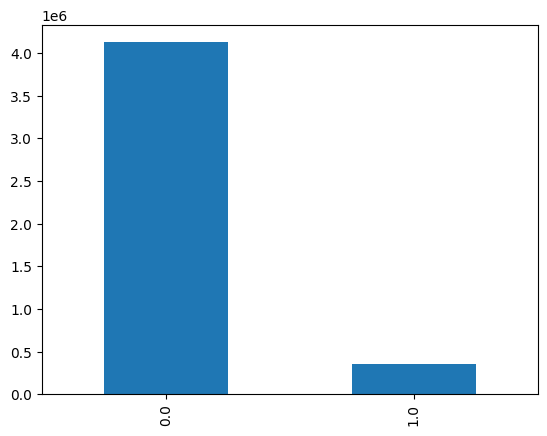

In [22]:
train['target'].value_counts().plot(kind='bar');

**Observation**

* The data is imbalance, but no worries we are expected to predict the probabilities.

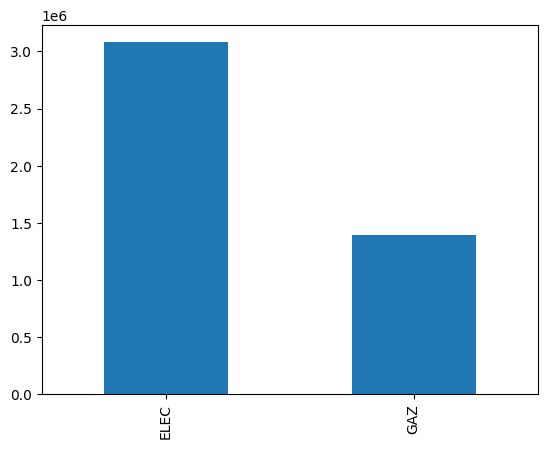

In [26]:
train['counter_type'].value_counts().plot(kind='bar');

**Observation**
Most of the data seems to be categorical

**Tips**

* Correct some features to the right datatypes.

* Find a suitable techniques to convert the categorical data.

### Feature engineering

* Generate date time features.

In [31]:
train.columns[train.columns.str.contains('date')]

Index(['creation_date', 'invoice_date'], dtype='object')

In [ ]:
train['creation_date'] = pd.to_datetime(train['creation_date'])
train['invoice_date'] = pd.to_datetime(train['invoice_date'])

test['creation_date'] = pd.to_datetime(test['creation_date'])
test['invoice_date'] = pd.to_datetime(test['invoice_date'])

In [33]:
train['dow_cd'] = train['creation_date'].dt.dayofweek
train['year_cd'] = train['creation_date'].dt.year
train['month_cd'] = train['creation_date'].dt.month

test['dow_cd'] = test['creation_date'].dt.dayofweek
test['year_cd'] = test['creation_date'].dt.year
test['month_cd'] = test['creation_date'].dt.month

In [34]:
train['dow_ind'] = train['invoice_date'].dt.dayofweek
train['year_ind'] = train['invoice_date'].dt.year
train['month_ind'] = train['invoice_date'].dt.month

test['dow_ind'] = test['invoice_date'].dt.dayofweek
test['year_ind'] = test['invoice_date'].dt.year
test['month_ind'] = test['invoice_date'].dt.month

### Feature selection

* drop some features

In [38]:
test_id = test['client_id']

In [39]:
to_drop = ['invoice_date', 'creation_date', 'old_index', 'new_index','client_id']

In [40]:
train = train.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

### encode the categorical data

In [46]:
lb = LabelEncoder()

In [47]:
train.select_dtypes('O').columns

Index(['counter_statue', 'counter_type'], dtype='object')

In [49]:
train['counter_statue'] = train['counter_statue'].astype(str)
test['counter_statue'] = test['counter_statue'].astype(str)

In [50]:
train['counter_statue'] = lb.fit_transform(train['counter_statue'])
train['counter_type'] = lb.fit_transform(train['counter_type'])

In [51]:
test['counter_statue'] = lb.fit_transform(test['counter_statue'])
test['counter_type'] = lb.fit_transform(test['counter_type'])

### Machine learning

In [52]:
X = train.drop('target', axis=1)
y = train['target']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101,stratify=y)
# shape of the data of train and validation set
print('Shape of the X_train {}'.format(X_train.shape))
print('Shape of the y_train {}'.format(y_train.shape))
print('Shape of the X_test {}'.format(X_test.shape))
print('Shape of the y_test {}'.format(y_test.shape))

Shape of the X_train (3357561, 21)
Shape of the y_train (3357561,)
Shape of the X_test (1119188, 21)
Shape of the y_test (1119188,)


In [55]:
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'auc'
    params["max_depth"] = -1
    params["num_leaves"] = 31

In [56]:
from lightgbm import LGBMClassifier # intializing the model
model = LGBMClassifier(**params)

In [58]:
model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100)

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's auc: 0.656258	valid_1's auc: 0.655367
[2]	training's auc: 0.662415	valid_1's auc: 0.661275
[3]	training's auc: 0.6678	valid_1's auc: 0.666906
[4]	training's auc: 0.67055	valid_1's auc: 0.669738
[5]	training's auc: 0.672821	valid_1's auc: 0.671986
[6]	training's auc: 0.675153	valid_1's auc: 0.674224
[7]	training's auc: 0.67945	valid_1's auc: 0.678127
[8]	training's auc: 0.680831	valid_1's auc: 0.679522
[9]	training's auc: 0.681863	valid_1's auc: 0.680747
[10]	training's auc: 0.683314	valid_1's auc: 0.682155
[11]	training's auc: 0.684245	valid_1's auc: 0.683045
[12]	training's auc: 0.686192	valid_1's auc: 0.684869
[13]	training's auc: 0.687295	valid_1's auc: 0.685994
[14]	training's auc: 0.68823	valid_1's auc: 0.686831
[15]	training's auc: 0.6896	valid_1's auc: 0.688256
[16]	training's auc: 0.690583	valid_1's auc: 0.689112
[17]	training's auc: 0.691568	valid_1's auc: 0.690267
[18]	training's auc: 0.692932	valid_1's auc: 0.691634
[19]	training's auc: 0.694349	valid_1's auc:

LGBMClassifier(metric='auc', objective='binary')

In [60]:
y_pred = model.predict_proba(X_test)[:, 1]
print('AUC score of the model is {}'.format(roc_auc_score(y_test, y_pred)))

AUC score of the model is 0.7326748416806039


In [59]:
prediction = model.predict_proba(test)[:, 1]

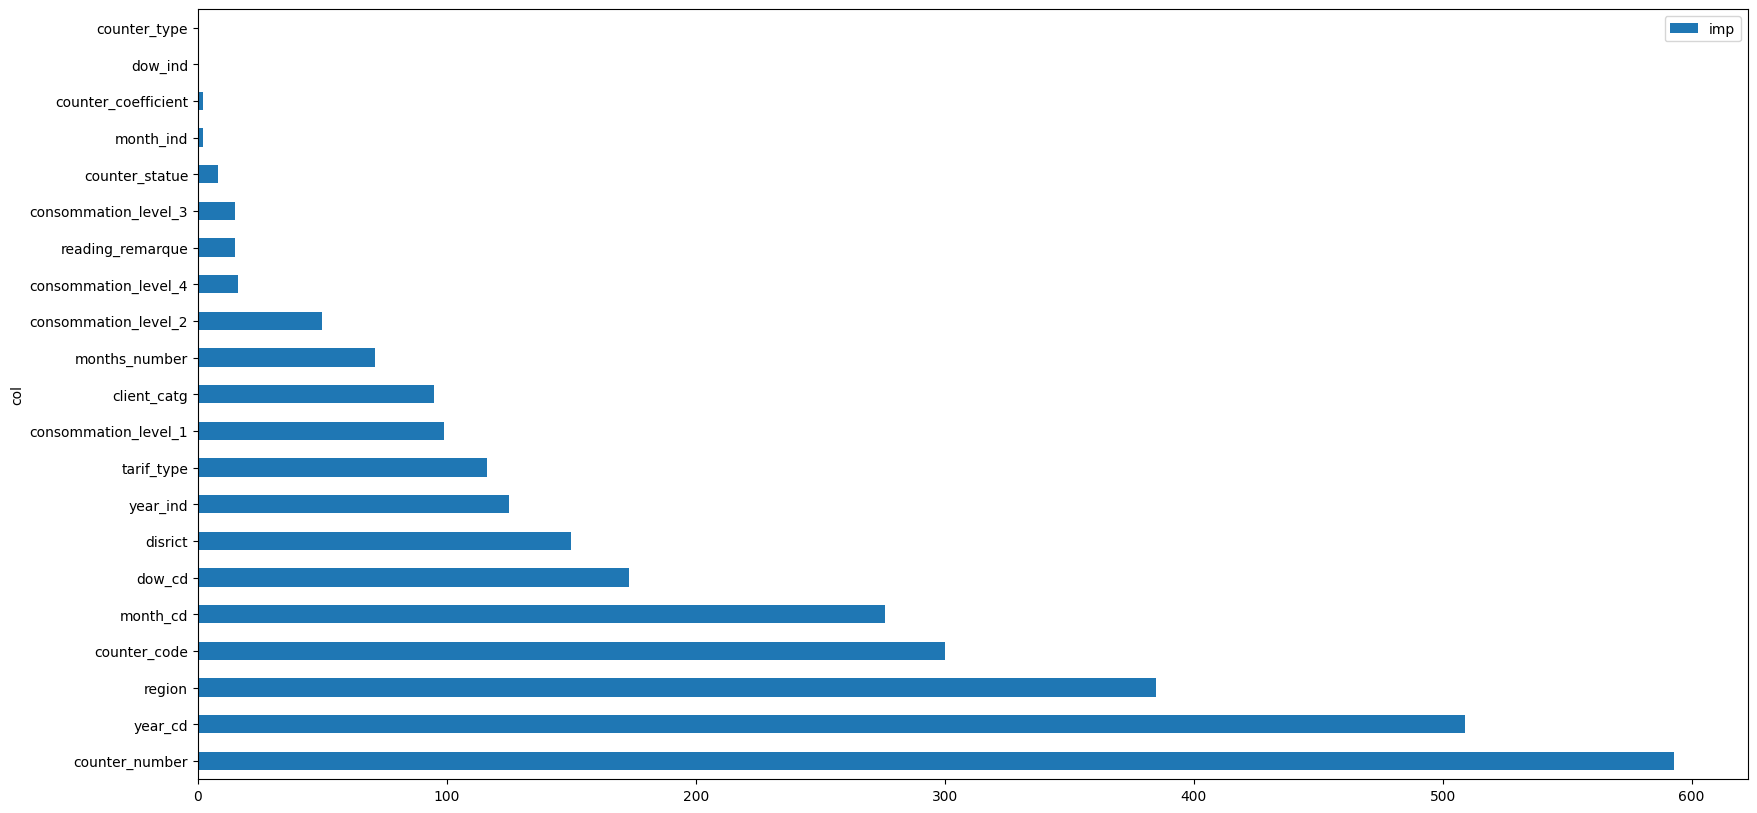

In [61]:
fea_imp = pd.DataFrame({'imp':model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=False).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))   

### Make prediction

In [69]:
sub = pd.DataFrame({'test_id':test_id, 'target':prediction})

In [70]:
sub.head()

,test_id,target
0,test_Client_0,0.039645
1,test_Client_0,0.066968
2,test_Client_0,0.113089
3,test_Client_0,0.063270
4,test_Client_0,0.063270


In [72]:
print(submission.shape)
print(test_id.shape)
print(sub.shape)

(58069, 2)
(1939730,)
(1939730, 2)


**Post pre-process**

* we observe we have more test id than id in the submission file.

In [73]:
test_id.nunique()

58069

In [80]:
## Take maximum value of each id
sub = sub.groupby('test_id')['target'].max().reset_index()

In [81]:
sub.head()

,test_id,target
0,test_Client_0,0.113089
1,test_Client_1,0.267191
2,test_Client_10,0.078855
3,test_Client_100,0.075822
4,test_Client_1000,0.083844


In [83]:
sub.to_csv('base_indabax.csv', index=False)

### Tips to win

* perform more EDA

* Feature engineering

* Different machine learning models

* hyperparameters tunning

* post process your prediction.

* Ensemble method.